In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')  
nltk.download('wordnet')  

import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab

from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Laura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Laura\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
lines = pd.read_csv("the-office-lines-simplified.csv")
michael = pd.read_csv("michael-not-michael.csv")
six_classes = pd.read_csv("6-classes.csv")

In [50]:
print(six_classes.shape)
other = six_classes[six_classes.speaker_id == 0].index
michael = six_classes[six_classes.speaker_id == 1].index
size = sum(six_classes.speaker_id == 5)

six_classes['line_text'] = [line.lower() for line in six_classes['line_text']]

undersampled = None
for i in range(6):
    other = six_classes[six_classes.speaker_id == i].index
    random_indices = np.random.choice(other, size, replace=False)
    other_sample = six_classes.loc[random_indices]
#    undersampled = undersampled.drop(undersampled[undersampled.speaker_id == i].index)
    undersampled = pd.concat([undersampled, other_sample])

# undersample the "other" speaker category to fix imbalanced sample sizes.

#random_indices = np.random.choice(michael, size, replace=False)
#michael_sample = except_other.loc[random_indices]
#except_michael = except_other.drop(except_other[except_other.speaker_id == 1].index)

print(undersampled.shape)

(59909, 2)
(23808, 2)


In [4]:
characters = {
    "Michael":1,"Dwight":2,"Jim":3,"Pam":4,"Andy":5,"Kevin":6,"Angela":7,
    "Oscar":8,"Erin":9,"Ryan":10,"Darryl":11,"Phyllis":12,"Kelly":13,"Jan":14,"Toby":15,"Other":16
}

In [30]:
characters6 = {
    "Other":0,"Michael":1,"Dwight":2,"Jim":3,"Pam":4,"Andy":5
}
six_class_names = ["Other","Michael","Dwight","Jim","Pam","Andy"]

Text(0.5,1,'Distribution of lines by character in "The Office"')

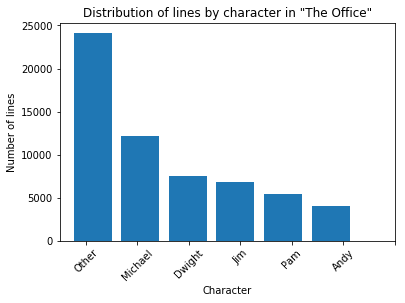

In [86]:
n = 6
fig, ax = plt.subplots(1, 1)
ax.hist(six_classes['speaker_id'], bins=n,rwidth=0.8)
plt.xticks(np.arange(0.3,n,0.9),characters6.keys(),rotation="45")
plt.xlabel("Character")
plt.ylabel("Number of lines")
plt.title("Distribution of lines by character in \"The Office\"")

Text(0.5,1,'Distribution of lines by character in "The Office" after undersampling')

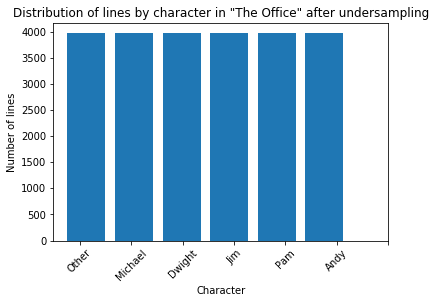

In [40]:
n = len(characters6.keys())
fig, ax = plt.subplots(1, 1)
ax.hist(undersampled['speaker_id'], bins=n,rwidth=0.8)
plt.xticks(np.arange(0.3,n,0.9),characters6.keys(),rotation="45")
plt.xlabel("Character")
plt.ylabel("Number of lines")
plt.title("Distribution of lines by character in \"The Office\" after undersampling")

In [4]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [5]:
def get_training_testing(data):
    X_train, X_test, y_train, y_test = train_test_split(data['line_text'], data['speaker_id'], test_size=0.2)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [51]:
# Generate training/testing splits
X_train, X_test, y_train, y_test = get_training_testing(undersampled)
#X_train, X_test, y_train, y_test = get_training_testing(excluding_other)

(19046,) (19046,)
(4762,) (4762,)


In [7]:
def remove_special_chars(sent):
    stripped = re.sub('[^\w\s]','',sent)
    stripped = re.sub('_', ' ', stripped)
    stripped = re.sub('\s+', ' ', stripped)
    stripped = stripped.strip()
    return stripped

In [57]:
def logistic_regression(X_train, X_test, y_train, y_test):
    clf = LogisticRegression().fit(X_train, y_train)
    predicted_train = clf.predict(X_train)
    predicted_test = clf.predict(X_test)
    print("Logistic Regression Training accuracy: ",np.mean(predicted_train == y_train))
    print("Logistic Regression Testing accuracy: ", np.mean(predicted_test == y_test))
    print("Logistic Regression Training Score: ", clf.score(X_train, y_train))
    print("Logistic Regression Testing Score: ", clf.score(X_test, y_test))
    print()
    plot_confusion_matrix(y_train, predicted_train, classes,title='Training Confusion matrix (Logistic Regression)')
    plot_confusion_matrix(y_test, predicted_test, classes,title='Testing Confusion matrix (Logistic Regression)')
    plt.show()
    return predicted_train, predicted_test

In [56]:
def svm(X_train, X_test, y_train, y_test):
    clf_svc = LinearSVC().fit(X_train,y_train)
    predicted_train = clf_svc.predict(X_train)
    predicted_test = clf_svc.predict(X_test)
    print("SVM Training accuracy: ",np.mean(predicted_train == y_train))
    print("SVM Testing accuracy: ", np.mean(predicted_test == y_test))
    print("SVM Training Score: ", clf_svc.score(X_train, y_train))
    print("SVM Testing Score: ", clf_svc.score(X_test, y_test))
    print()
    plot_confusion_matrix(y_train, predicted_train, classes,title='Training Confusion matrix (SVM)')
    plot_confusion_matrix(y_test, predicted_test, classes,title='Testing Confusion matrix (SVM)')
    plt.show()
    return predicted_train, predicted_test

In [59]:
def naive_bayes(X_train, X_test, y_train, y_test):
    clf = MultinomialNB().fit(X_train, y_train)
    predicted_train = clf.predict(X_train)
    predicted_test = clf.predict(X_test)
    print("Naive Bayes Training accuracy: ",np.mean(predicted_train == y_train))
    print("Naive Bayes Testing accuracy: ", np.mean(predicted_test == y_test))
    print("Naive Bayes Training Score: ", clf.score(X_train, y_train))
    print("Naive Bayes Testing Score: ", clf.score(X_test, y_test))
    print()
    plot_confusion_matrix(y_train, predicted_train, classes,title='Training Confusion matrix (Naive Bayes)')
    plot_confusion_matrix(y_test, predicted_test, classes,title='Testing Confusion matrix (Naive Bayes)')
    plt.show()
    return predicted_train, predicted_test

In [60]:
def neural_network(X_train, X_test, y_train, y_test):
    clf = MLPClassifier().fit(X_train, y_train)
    predicted_train = clf.predict(X_train)
    predicted_test = clf.predict(X_test)
    print("Neural Network Training accuracy: ",np.mean(predicted_train == y_train))
    print("Neural Network Testing accuracy: ", np.mean(predicted_test == y_test))
    print("Neural Network Training Score: ", clf.score(X_train, y_train))
    print("Neural Network Testing Score: ", clf.score(X_test, y_test))
    print()    
    plot_confusion_matrix(y_train, predicted_train, classes,title='Training Confusion matrix (Neural Network)')
    plot_confusion_matrix(y_test, predicted_test, classes,title='Testing Confusion matrix (Neural Network)')
    plt.show()
    return predicted_train, predicted_test

In [12]:
def apply_pca(X_train, X_test, n_components=100):
    pca = decomposition.TruncatedSVD(n_components = 100)
    pca_X_train = pca.fit_transform(X_train)
    pca_X_test = pca.transform(X_test)
    return pca_X_train, pca_X_test

In [13]:
def scale_data(X_train, X_test):
    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)
    return X_train, X_test

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [16]:
# get raw count vectors using lemmatizer
lemma_count_vect = CountVectorizer(tokenizer=LemmaTokenizer(),analyzer='word', token_pattern=r'\w{1,}')
lemma_X_train_counts =  lemma_count_vect.fit_transform(X_train)
# get tf-idf vectors
lemma_tfidf_transformer = TfidfTransformer()
lemma_X_train_tfidf =  lemma_tfidf_transformer.fit_transform(lemma_X_train_counts)

lemma_X_test_counts = lemma_count_vect.transform(X_test)
lemma_X_test_tfidf = lemma_tfidf_transformer.transform(lemma_X_test_counts)

lemma_X_train_tfidf,lemma_X_test_tfidf = scale_data(lemma_X_train_tfidf,lemma_X_test_tfidf)
lemma_X_train_counts,lemma_X_test_counts = scale_data(lemma_X_train_counts,lemma_X_test_counts)
print(lemma_X_train_tfidf.shape)
n_components = 500
print("Reducing dimensionality of tfidf scores to n =", n_components)
lemma_X_train_tfidf,lemma_X_test_tfidf = apply_pca(lemma_X_train_tfidf,lemma_X_test_tfidf,n_components)

print("Reducing dimensionality to count scores to n =", n_components)
lemma_X_train_counts,lemma_X_test_counts = apply_pca(lemma_X_train_counts,lemma_X_test_counts,n_components)

C:\Program Files\Python36\Lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(30996, 15436)
Reducing dimensionality of tfidf scores to n = 500
Reducing dimensionality to count scores to n = 500


In [41]:
#classes = ["0","1","2","3","4","5"]
classes = ["Other","Michael","Dwight","Jim","Pam","Andy"]

C:\Program Files\Python36\Lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Reducing dimensionality of tfidf scores to n = 100
Reducing dimensionality to count scores to n = 100
Using lemmatized tf-idf scores.


C:\Program Files\Python36\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Network Training accuracy:  0.35834295915152786
Neural Network Testing accuracy:  0.26858462830743385
Neural Network Training Score:  0.35834295915152786
Neural Network Testing Score:  0.26858462830743385

Normalized confusion matrix
Normalized confusion matrix


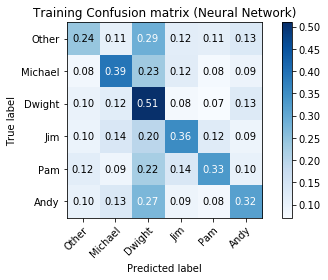

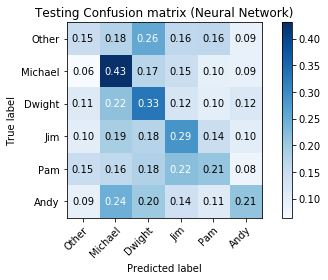

Logistic Regression Training accuracy:  0.2658300955581224
Logistic Regression Testing accuracy:  0.248635027299454
Logistic Regression Training Score:  0.2658300955581224
Logistic Regression Testing Score:  0.248635027299454

Normalized confusion matrix
Normalized confusion matrix


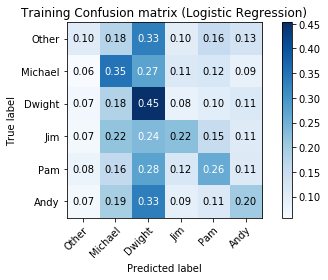

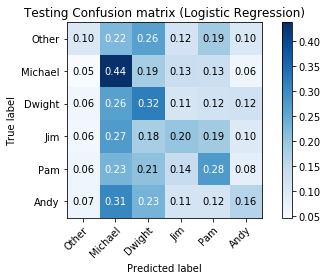

SVM Training accuracy:  0.26661766250131264
SVM Testing accuracy:  0.24653506929861402
SVM Training Score:  0.26661766250131264
SVM Testing Score:  0.24653506929861402

Normalized confusion matrix
Normalized confusion matrix


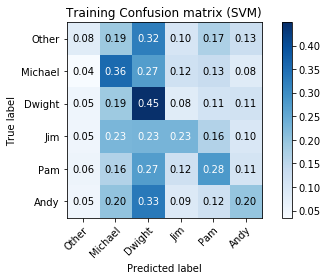

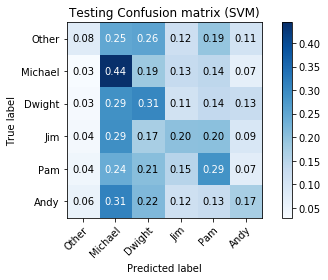

Using lemmatized count scores.
Neural Network Training accuracy:  0.48020581749448704
Neural Network Testing accuracy:  0.23519529609407813
Neural Network Training Score:  0.48020581749448704
Neural Network Testing Score:  0.23519529609407813

Normalized confusion matrix
Normalized confusion matrix


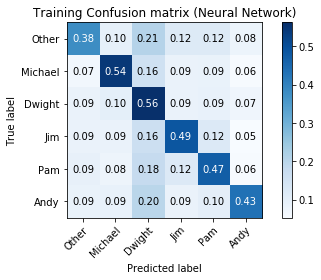

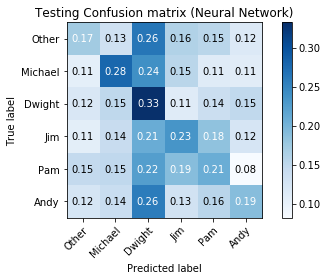

Logistic Regression Training accuracy:  0.2720781266407645
Logistic Regression Testing accuracy:  0.252834943301134
Logistic Regression Training Score:  0.2720781266407645
Logistic Regression Testing Score:  0.252834943301134

Normalized confusion matrix
Normalized confusion matrix


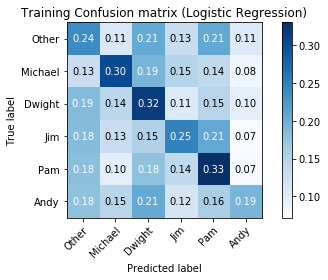

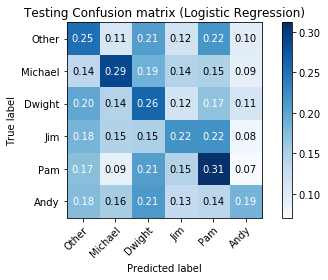

SVM Training accuracy:  0.26887535440512444
SVM Testing accuracy:  0.253044939101218
SVM Training Score:  0.26887535440512444
SVM Testing Score:  0.253044939101218

Normalized confusion matrix
Normalized confusion matrix


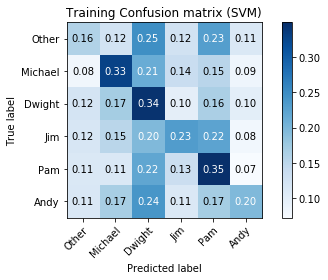

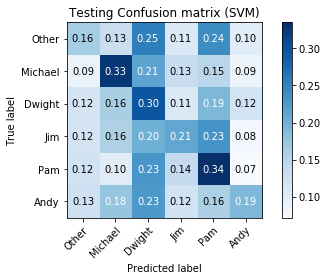

(array([5, 1, 4, ..., 2, 4, 4], dtype=int64),
 array([0, 0, 4, ..., 4, 0, 5], dtype=int64))

In [61]:
pylab.ion()
n = 3
lemma_count_vect = CountVectorizer(tokenizer=LemmaTokenizer(),analyzer='word',stop_words="english",ngram_range=(1,n))
# get raw count vectors using lemmatizer
lemma_X_train_counts =  lemma_count_vect.fit_transform(X_train)

# get tf-idf vectors
lemma_tfidf_transformer = TfidfTransformer()
lemma_X_train_tfidf =  lemma_tfidf_transformer.fit_transform(lemma_X_train_counts)

lemma_X_test_counts = lemma_count_vect.transform(X_test)
lemma_X_test_tfidf = lemma_tfidf_transformer.transform(lemma_X_test_counts)

lemma_X_train_tfidf,lemma_X_test_tfidf = scale_data(lemma_X_train_tfidf,lemma_X_test_tfidf)
lemma_X_train_counts,lemma_X_test_counts = scale_data(lemma_X_train_counts,lemma_X_test_counts)

n_components = 100
print("Reducing dimensionality of tfidf scores to n =", n_components)
lemma_X_train_tfidf,lemma_X_test_tfidf = apply_pca(lemma_X_train_tfidf,lemma_X_test_tfidf,n_components)
print("Reducing dimensionality to count scores to n =", n_components)
lemma_X_train_counts,lemma_X_test_counts = apply_pca(lemma_X_train_counts,lemma_X_test_counts,n_components)

print("Using lemmatized tf-idf scores.")
neural_network(lemma_X_train_tfidf,lemma_X_test_tfidf,y_train,y_test)
logistic_regression(lemma_X_train_tfidf,lemma_X_test_tfidf,y_train,y_test)
svm(lemma_X_train_tfidf,lemma_X_test_tfidf,y_train,y_test)
#naive_bayes(lemma_X_train_tfidf,lemma_X_test_tfidf,y_train,y_test)

print("Using lemmatized count scores.")
neural_network(lemma_X_train_counts,lemma_X_test_counts,y_train,y_test)
logistic_regression(lemma_X_train_counts,lemma_X_test_counts,y_train,y_test)
svm(lemma_X_train_counts,lemma_X_test_counts,y_train,y_test)
#naive_bayes(lemma_X_train_counts,lemma_X_test_counts,y_train,y_test)

C:\Program Files\Python36\Lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using lemmatized tf-idf scores.
Naive Bayes Training accuracy:  0.8247401029087472
Naive Bayes Testing accuracy:  0.3049139017219656

Normalized confusion matrix
Normalized confusion matrix


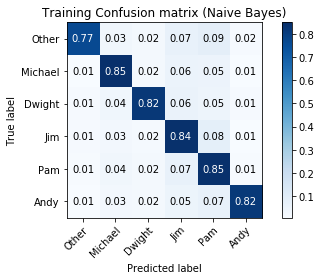

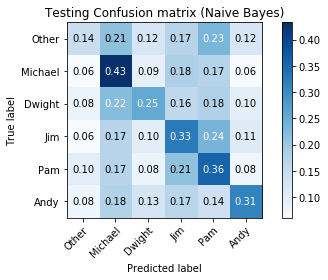

Using lemmatized count scores.
Naive Bayes Training accuracy:  0.7871469074871364
Naive Bayes Testing accuracy:  0.3017639647207056

Normalized confusion matrix
Normalized confusion matrix


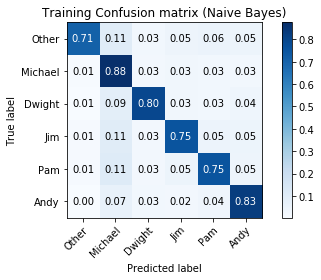

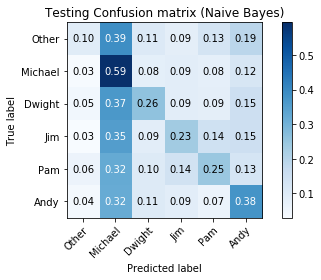

(array([4, 2, 4, ..., 2, 3, 1], dtype=int64),
 array([3, 1, 1, ..., 4, 5, 1], dtype=int64))

In [53]:
pylab.ion()
n = 3
lemma_count_vect = CountVectorizer(tokenizer=LemmaTokenizer(),analyzer='word',stop_words="english",ngram_range=(1,n))
# get raw count vectors using lemmatizer
lemma_X_train_counts =  lemma_count_vect.fit_transform(X_train)

# get tf-idf vectors
lemma_tfidf_transformer = TfidfTransformer()
lemma_X_train_tfidf =  lemma_tfidf_transformer.fit_transform(lemma_X_train_counts)

lemma_X_test_counts = lemma_count_vect.transform(X_test)
lemma_X_test_tfidf = lemma_tfidf_transformer.transform(lemma_X_test_counts)

lemma_X_train_tfidf,lemma_X_test_tfidf = scale_data(lemma_X_train_tfidf,lemma_X_test_tfidf)
lemma_X_train_counts,lemma_X_test_counts = scale_data(lemma_X_train_counts,lemma_X_test_counts)

print("Using lemmatized tf-idf scores.")
naive_bayes(lemma_X_train_tfidf,lemma_X_test_tfidf,y_train,y_test)

print("Using lemmatized count scores.")
naive_bayes(lemma_X_train_counts,lemma_X_test_counts,y_train,y_test)

C:\Program Files\Python36\Lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Reducing dimensionality of tfidf scores to n = 100
Reducing dimensionality to count scores to n = 100
Using tf-idf scores.


C:\Program Files\Python36\Lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Network Training accuracy:  0.46831639785507123
Neural Network Testing accuracy:  0.39793022867634786

Confusion matrix, without normalization
Confusion matrix, without normalization


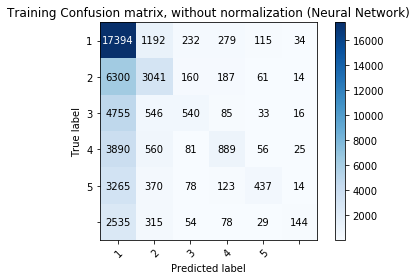

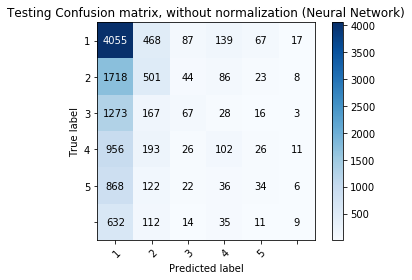

Logistic Regression Training accuracy:  0.4068479145366912
Logistic Regression Testing accuracy:  0.41061592388582874

Confusion matrix, without normalization
Confusion matrix, without normalization


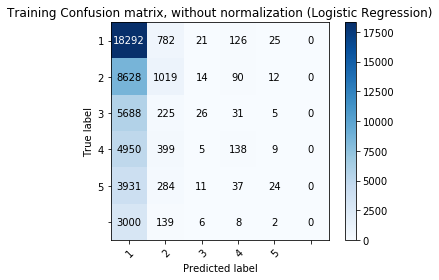

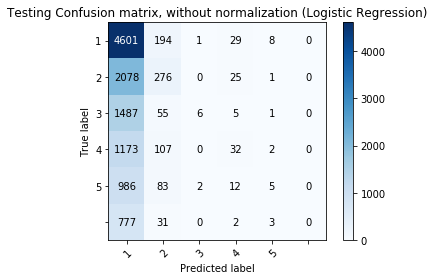

KeyboardInterrupt: 

In [73]:
pylab.ion()
ngrams = [1,2,3]
for n in ngrams:
    count_vect = CountVectorizer(analyzer='word',stop_words="english",ngram_range=(1,n))
    X_train_counts =  count_vect.fit_transform(X_train)
    
    # get tf-idf vectors
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf =  tfidf_transformer.fit_transform(X_train_counts)
    X_test_counts = count_vect.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)

    X_train_tfidf, X_test_tfidf = scale_data(X_train_tfidf,X_test_tfidf)
    X_train_counts,X_test_counts = scale_data(X_train_counts,X_test_counts)

    n_components = 100
    print("Reducing dimensionality of tfidf scores to n =", n_components)
    X_train_tfidf, X_test_tfidf = apply_pca(X_train_tfidf, X_test_tfidf, n_components)
    print("Reducing dimensionality to count scores to n =", n_components)
    X_train_counts, X_test_counts = apply_pca(X_train_counts, X_test_counts, n_components)

    print("Using tf-idf scores.")
    neural_network(X_train_tfidf,X_test_tfidf,y_train,y_test)
    logistic_regression(X_train_tfidf,X_test_tfidf,y_train,y_test)
    svm(X_train_tfidf,X_test_tfidf,y_train,y_test)
    #naive_bayes(X_train_tfidf,X_test_tfidf,y_train,y_test)

    print("Using raw count scores.")
    neural_network(X_train_counts,X_test_counts,y_train,y_test)
    logistic_regression(X_train_counts,X_test_counts,y_train,y_test)
    svm(lemma_X_train_counts,X_test_counts,y_train,y_test)
    #naive_bayes(X_train_counts,X_test_counts,y_train,y_test)

Next we will try using SVMs for classification. 

What if we apply PCA before classification?

In [38]:
# get raw count vectors
errors = []
ngrams = [1,2,3]
for n in ngrams:
    Ngram_count_vect = CountVectorizer(analyzer='word',stop_words="english",ngram_range=(1,n))
    Ngram_X_train_counts =  Ngram_count_vect.fit_transform(X_train)
    Ngram_X_test_counts = Ngram_count_vect.transform(X_test)
    
    neural_network(X_test_tfidf,X_test_tfidf,y_test,y_test)
     # fit NB model to N-gram raw counts
    clf = MultinomialNB().fit(Ngram_X_train_counts, y_train)
    
    # run model on training and testing data using raw counts
    Ngram_predicted_train = clf.predict(Ngram_X_train_counts)
    Ngram_predicted_test = clf.predict(Ngram_X_test_counts)
    print("Running Naive Bayes on ",n,"-gram raw count scores.")
    print("Naive Bayes Training accuracy: ",np.mean(Ngram_predicted_train == y_train))
    print("Naive Bayes Testing accuracy: ", np.mean(Ngram_predicted_test == y_test))
    print()
    errors.append(["Naive Bayes " + n + " count vectors (train)", np.mean(Ngram_predicted_train == y_train)])
    errors.append(["Naive Bayes " + n + " count vectors (test)", np.mean(Ngram_predicted_test == y_test)])
    
    clf_svc = LinearSVC().fit(Ngram_X_train_counts,y_train)
    svm_predicted_train = clf_svc.predict(Ngram_X_train_counts)
    svm_predicted_test = clf_svc.predict(Ngram_X_test_counts)
    print("Running SVM on ",n,"-gram raw-count scores.")
    print("SVM Training accuracy: ",np.mean(svm_predicted_train == y_train))
    print("SVM Testing accuracy: ", np.mean(svm_predicted_test == y_test))
    print()
    errors.append(["SVM " + n + " count vectors (train)", np.mean(svm_predicted_train == y_train)])
    errors.append(["SVM " + n + " count vectors (test)", np.mean(svm_predicted_test == y_test)])
    
    # get tf-idf vectors
    Ngram_tfidf_transformer = TfidfTransformer()
    Ngram_X_train_tfidf =  Ngram_tfidf_transformer.fit_transform(Ngram_X_train_counts)
    Ngram_X_test_tfidf = Ngram_tfidf_transformer.transform(Ngram_X_test_counts)

    # fit model to N-gram tf-idfs
    clf = MultinomialNB().fit(Ngram_X_train_tfidf, y_train)

    # run model on training and testing data
    Ngram_predicted_train = clf.predict(Ngram_X_train_tfidf)
    Ngram_predicted_test = clf.predict(Ngram_X_test_tfidf)
    print("Running Naive Bayes on ",n,"-gram TF-IDF scores.")
    print("Naive Bayes Training accuracy: ",np.mean(Ngram_predicted_train == y_train))
    print("Naive Bayes Testing accuracy: ", np.mean(Ngram_predicted_test == y_test))
    print()
    
    clf_svc = LinearSVC().fit(Ngram_X_train_tfidf,y_train)
    svm_predicted_train = clf_svc.predict(Ngram_X_train_tfidf)
    svm_predicted_test = clf_svc.predict(Ngram_X_test_tfidf)
    print("Running SVM on ",n,"-gram TF-IDF scores.")
    print("SVM Training accuracy: ",np.mean(svm_predicted_train == y_train))
    print("SVM Testing accuracy: ", np.mean(svm_predicted_test == y_test))
    print()

Running Naive Bayes on  1 -gram raw count scores.
Naive Bayes Training accuracy:  0.8414255012832015
Naive Bayes Testing accuracy:  0.7860958103822401



TypeError: must be str, not int

In [39]:
ngrams = [1,2,3]
for n in ngrams:
    Ngram_count_vect = CountVectorizer(analyzer='word',stop_words="english",ngram_range=(1,n))
    Ngram_X_train_counts =  Ngram_count_vect.fit_transform(X_train)
    Ngram_X_test_counts = Ngram_count_vect.transform(X_test)
    
     # fit NB model to N-gram raw counts
    clf = LogisticRegression().fit(Ngram_X_train_counts, y_train)
    
    # run model on training and testing data using raw counts
    Ngram_predicted_train = clf.predict(Ngram_X_train_counts)
    Ngram_predicted_test = clf.predict(Ngram_X_test_counts)
    print("Running Logistic Regression on ",n,"-gram raw count scores.")
    print("Logistic Regression Training accuracy: ",np.mean(Ngram_predicted_train == y_train))
    print("Logistic Regression Testing accuracy: ", np.mean(Ngram_predicted_test == y_test))
    print()
    
    # get tf-idf vectors
    Ngram_tfidf_transformer = TfidfTransformer()
    Ngram_X_train_tfidf =  Ngram_tfidf_transformer.fit_transform(Ngram_X_train_counts)
    Ngram_X_test_tfidf = Ngram_tfidf_transformer.transform(Ngram_X_test_counts)

    # fit model to N-gram tf-idfs
    clf = MultinomialNB().fit(Ngram_X_train_tfidf, y_train)

    # run model on training and testing data
    Ngram_predicted_train = clf.predict(Ngram_X_train_tfidf)
    Ngram_predicted_test = clf.predict(Ngram_X_test_tfidf)
    print("Running Logistic Regression on ",n,"-gram TF-IDF scores.")
    print("Logistic Regression Training accuracy: ",np.mean(Ngram_predicted_train == y_train))
    print("Logistic Regression Testing accuracy: ", np.mean(Ngram_predicted_test == y_test))
    print()

Running Logistic Regression on  1 -gram raw count scores.
Logistic Regression Training accuracy:  0.8448265069793645
Logistic Regression Testing accuracy:  0.7958604573526957

Running Logistic Regression on  1 -gram TF-IDF scores.
Logistic Regression Training accuracy:  0.8061218102530933
Logistic Regression Testing accuracy:  0.7905191120013353

Running Logistic Regression on  2 -gram raw count scores.
Logistic Regression Training accuracy:  0.9096125357314249
Logistic Regression Testing accuracy:  0.7981972959439159

Running Logistic Regression on  2 -gram TF-IDF scores.
Logistic Regression Training accuracy:  0.7995910447138356
Logistic Regression Testing accuracy:  0.7912702386913704

Running Logistic Regression on  3 -gram raw count scores.
Logistic Regression Training accuracy:  0.9230079078598702
Logistic Regression Testing accuracy:  0.801118344182941

Running Logistic Regression on  3 -gram TF-IDF scores.
Logistic Regression Training accuracy:  0.7990902831389405
Logistic Regr

In [77]:
def accuracy(predicted, actual):
    correct = 0
    for p, a in zip(predicted, actual):
        correct += 1 if p == a else 0
    return 100 * correct / len(predicted)

In [120]:
def get_count_matrix(corpus):
    n = len(corpus)
    print(n, " documents in corpus.")
    all_words = []
    for sent in corpus:
        words = get_words(sent)
        for word in words:
            if word not in all_words:
                all_words.append(word)
    m = len(all_words)# number of words in corpus
    print(m, " words in corpus.")
    doc_count = np.zeros(m)
    count_matrix = np.zeros((n,m))
    for i in range(n):
        sent_i = remove_special_chars(corpus[i].lower())
        for j in range(m):
            word_j = all_words[j]
            if word_j in sent_i:
                doc_count[j] += 1
                for word in get_words(sent_i):
                    if word == word_j:
                        count_matrix[i][j] += 1
    return count_matrix, all_words, doc_count

In [117]:
def get_tfidf_matrix(corpus, count_matrix, doc_count):
    n,m = count_matrix.shape
    tfidf_matrix = np.zeros((n,m))
    print(tfidf_matrix.shape)
    print(count_matrix.shape)
    for i in range(n):
        for j in range(m):
            tf = count_matrix[i][j] / sum(count_matrix[i][:])
            idf = math.log(n / doc_count[j])
            tfidf_matrix[i][j] = tf * idf
    return tfidf_matrix

In [118]:
count_matrix, all_words, doc_count = get_count_matrix(michael['line_text'])
tfidf_matrix = get_tfidf_matrix(michael['line_text'], count_matrix, doc_count)

12143  documents in corpus.


C:\Program Files\Python36\Lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files\Python36\Lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


KeyError: 1

In [102]:
write_matrix_to_file(count_matrix, all_words, "count_matrix.csv")
write_matrix_to_file(tfidf_matrix, all_words, "tfidf_matrix.csv")

In [101]:
def write_matrix_to_file(matrix, words, output):
    header = ""
    for i in range(len(words)-1):
        header += words[i] + ","
    header += all_words[len(words)-1]
    np.savetxt(output, matrix, delimiter=",",fmt='%.4e',header=header,comments='')